In [22]:
from datetime import datetime
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Endereços dos dados
ENDERECO_DADOS = r'../bronze/'
ENDERECO_VOTACAO = r'../votacao/'

# ============================
# ETAPA 1: Importação dos Dados
# ============================

try:
    print('Obtendo os dados...')
    hora_inicial = datetime.now()

    df_bolsa_familia = pl.scan_parquet(ENDERECO_DADOS + 'bolsa_familia_str_cache.parquet')
    df_votacao = pl.read_csv(ENDERECO_VOTACAO + 'votacao_secao_2022_BR.csv', separator=';', encoding='iso-8859-1')

    print(df_votacao.head(5))
    print(df_votacao.columns)
    print(df_votacao.shape)

    hora_final = datetime.now()
    print(f'Tempo de execução: {hora_final - hora_inicial}')

except Exception as e:
    print(f'Erro ao importar os dados: {e}')

Obtendo os dados...
shape: (5, 26)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ DT_GERACA ┆ HH_GERACA ┆ ANO_ELEIC ┆ CD_TIPO_E ┆ … ┆ NR_LOCAL_ ┆ SQ_CANDID ┆ NM_LOCAL_ ┆ DS_LOCAL │
│ O         ┆ O         ┆ AO        ┆ LEICAO    ┆   ┆ VOTACAO   ┆ ATO       ┆ VOTACAO   ┆ _VOTACAO │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ _ENDEREC │
│ str       ┆ str       ┆ i64       ┆ i64       ┆   ┆ i64       ┆ i64       ┆ str       ┆ O        │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 01/11/202 ┆ 16:05:25  ┆ 2.022     ┆ 2         ┆ … ┆ 1.015     ┆ 280.001.6 ┆ CENTRO    ┆ AV.      │
│ 2         ┆           ┆           ┆           ┆   ┆   

In [23]:
# ============================
# ETAPA 2: Processamento
# ============================

try:
    print('Iniciando processamento...')
    hora_inicial = datetime.now()

    df_votacao = df_votacao.filter(
        (pl.col('NR_TURNO') == 2) & 
        (pl.col('NR_VOTAVEL').is_in([13, 22]))
    )

    with pl.StringCache():
        # Votação
        df_votacao = (
            df_votacao.lazy()
            .select(['SG_UF', 'NM_VOTAVEL', 'QT_VOTOS'])
            .with_columns([
                pl.col('SG_UF').cast(pl.Categorical),
                pl.col('NM_VOTAVEL').cast(pl.Categorical)
            ])
            .group_by(['SG_UF', 'NM_VOTAVEL'])
            .agg(pl.col('QT_VOTOS').sum())
            .collect()
        )

        # Bolsa Família
        df_bolsa_familia = (
            df_bolsa_familia.lazy()
            .select(['UF', 'VALOR PARCELA'])
            .with_columns([
                pl.col('UF').cast(pl.Categorical)
            ])
            .group_by('UF')
            .agg(pl.col('VALOR PARCELA').sum())
            .collect()
        )

        # Join
        df_votos_bolsa_familia = df_votacao.join(
            df_bolsa_familia, left_on='SG_UF', right_on='UF'
        )

    # Configurações de exibição
    pl.Config.set_float_precision(2)
    pl.Config.set_decimal_separator(',')
    pl.Config.set_thousands_separator('.')

    print(df_votos_bolsa_familia.head(5))

    hora_final = datetime.now()
    print(f'Tempo de processamento:  {hora_final - hora_inicial}')

except Exception as e:
    print(f'Erro ao processar os dados: {e}')


# ============================
# TOTALIZAÇÃO DOS VOTOS NACIONAIS - 2º TURNO
# ============================

print("\nTotalizando votos nacionais para o 2º turno...")

hora_inicio = datetime.now()

try:
    # Total de votos válidos por candidato
    total_votos = df_votacao.group_by("NM_VOTAVEL").agg(
        pl.col("QT_VOTOS").sum().alias("TOTAL_VOTOS")
    ).sort("TOTAL_VOTOS", descending=True)

    # Adicionar coluna de percentual
    total_geral = total_votos["TOTAL_VOTOS"].sum()
    total_votos = total_votos.with_columns([
        (pl.col("TOTAL_VOTOS") / total_geral * 100).alias("PERCENTUAL")
    ])

    # Exibir total por candidato
    print("\nTotal de votos por candidato no 2º turno (Brasil):")
    print(total_votos)

    # Obter valores individuais
    lula_votos = total_votos.filter(pl.col("NM_VOTAVEL").cast(pl.Utf8).str.contains("LULA"))[0, "TOTAL_VOTOS"]
    bolsonaro_votos = total_votos.filter(pl.col("NM_VOTAVEL").cast(pl.Utf8).str.contains("BOLSONARO"))[0, "TOTAL_VOTOS"]

except Exception as e:
    raise RuntimeError(f"Erro ao extrair totais de votos: {e}")




Iniciando processamento...
shape: (5, 4)
┌───────┬───────────────────────────┬───────────┬──────────────────┐
│ SG_UF ┆ NM_VOTAVEL                ┆ QT_VOTOS  ┆ VALOR PARCELA    │
│ ---   ┆ ---                       ┆ ---       ┆ ---              │
│ cat   ┆ cat                       ┆ i64       ┆ f64              │
╞═══════╪═══════════════════════════╪═══════════╪══════════════════╡
│ PA    ┆ LUIZ INÁCIO LULA DA SILVA ┆ 2.509.084 ┆ 4.653.641.809,00 │
│ PR    ┆ LUIZ INÁCIO LULA DA SILVA ┆ 2.506.605 ┆ 1.947.816.087,00 │
│ AC    ┆ JAIR MESSIAS BOLSONARO    ┆ 287.750   ┆ 470.918.235,00   │
│ MA    ┆ JAIR MESSIAS BOLSONARO    ┆ 1.082.749 ┆ 4.252.676.548,00 │
│ MA    ┆ LUIZ INÁCIO LULA DA SILVA ┆ 2.668.425 ┆ 4.252.676.548,00 │
└───────┴───────────────────────────┴───────────┴──────────────────┘
Tempo de processamento:  0:00:02.082420

Totalizando votos nacionais para o 2º turno...

Total de votos por candidato no 2º turno (Brasil):
shape: (2, 3)
┌───────────────────────────┬─────────────┬───

In [24]:
# ============================
# ETAPA 3: Ranqueamento Reverso
# ============================

try:
    print("Gerando ranqueamento reverso...")
    hora_inicio = datetime.now()

    df_pivot = df_votos_bolsa_familia.pivot(
        values="QT_VOTOS",
        index="SG_UF",
        columns="NM_VOTAVEL",
        aggregate_function="first"
    )

    df_pivot = df_pivot.rename({
        "LUIZ INÁCIO LULA DA SILVA": "LULA",
        "JAIR MESSIAS BOLSONARO": "BOLSONARO"
    })

    df_pivot = df_pivot.with_columns([
        (pl.col("LULA") - pl.col("BOLSONARO")).alias("DIF_LULA_MENOS_BOLSONARO")
    ])

    estados_lula = df_pivot.filter(pl.col("DIF_LULA_MENOS_BOLSONARO") > 0).sort("DIF_LULA_MENOS_BOLSONARO", descending=True)
    estados_bolsonaro = df_pivot.filter(pl.col("DIF_LULA_MENOS_BOLSONARO") < 0).sort("DIF_LULA_MENOS_BOLSONARO")

    print("\nEstados onde LULA venceu:")
    print(estados_lula.select(["SG_UF", "DIF_LULA_MENOS_BOLSONARO"]))

    print("\nEstados onde BOLSONARO venceu:")
    print(estados_bolsonaro.select(["SG_UF", "DIF_LULA_MENOS_BOLSONARO"]))

    hora_fim = datetime.now()
    print("Ranqueamento reverso gerado com sucesso! Tempo: ", hora_fim - hora_inicio)

except Exception as e:
    raise RuntimeError(f"Erro ao gerar ranqueamento reverso: {e}")

Gerando ranqueamento reverso...

Estados onde LULA venceu:
shape: (13, 2)
┌───────┬──────────────────────────┐
│ SG_UF ┆ DIF_LULA_MENOS_BOLSONARO │
│ ---   ┆ ---                      │
│ cat   ┆ i64                      │
╞═══════╪══════════════════════════╡
│ BA    ┆ 3.740.787                │
│ CE    ┆ 2.173.414                │
│ PE    ┆ 1.842.101                │
│ MA    ┆ 1.585.676                │
│ PI    ┆ 1.084.318                │
│ …     ┆ …                        │
│ PA    ┆ 435.189                  │
│ AL    ┆ 289.004                  │
│ MG    ┆ 49.650                   │
│ AM    ┆ 43.250                   │
│ TO    ┆ 22.939                   │
└───────┴──────────────────────────┘

Estados onde BOLSONARO venceu:
shape: (14, 2)
┌───────┬──────────────────────────┐
│ SG_UF ┆ DIF_LULA_MENOS_BOLSONARO │
│ ---   ┆ ---                      │
│ cat   ┆ i64                      │
╞═══════╪══════════════════════════╡
│ SP    ┆ -2.696.705               │
│ SC    ┆ -1.695.712        

C:\Users\User\AppData\Local\Temp\ipykernel_13804\582146547.py:9: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  df_pivot = df_votos_bolsa_familia.pivot(


Correlacionando os dados
Correlação para LUIZ INÁCIO LULA DA SILVA: 0.8968888927016996
Correlação para JAIR MESSIAS BOLSONARO: 0.6451146386646837
Correlação finalizada em 0:00:00.012866
Visualizando dados....


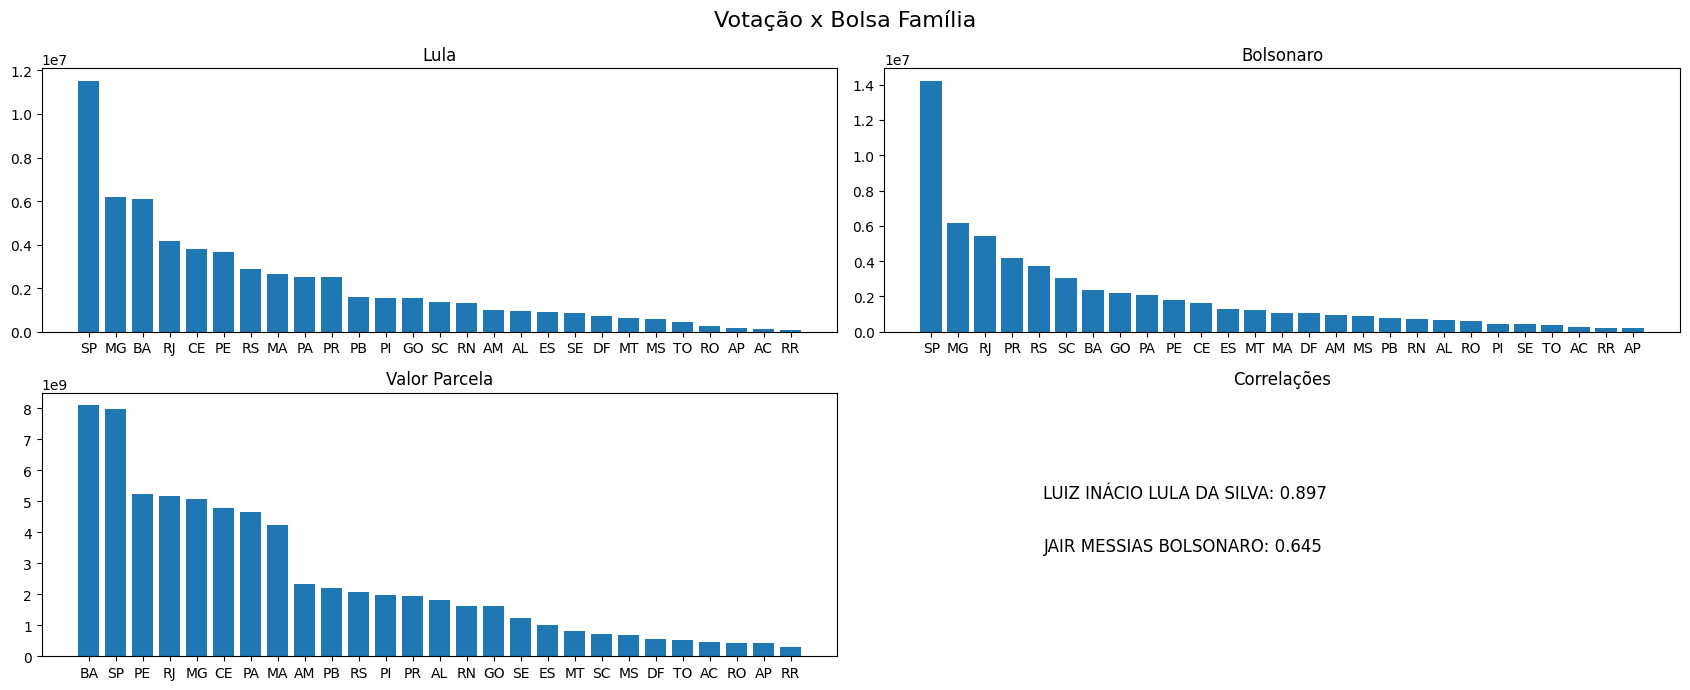

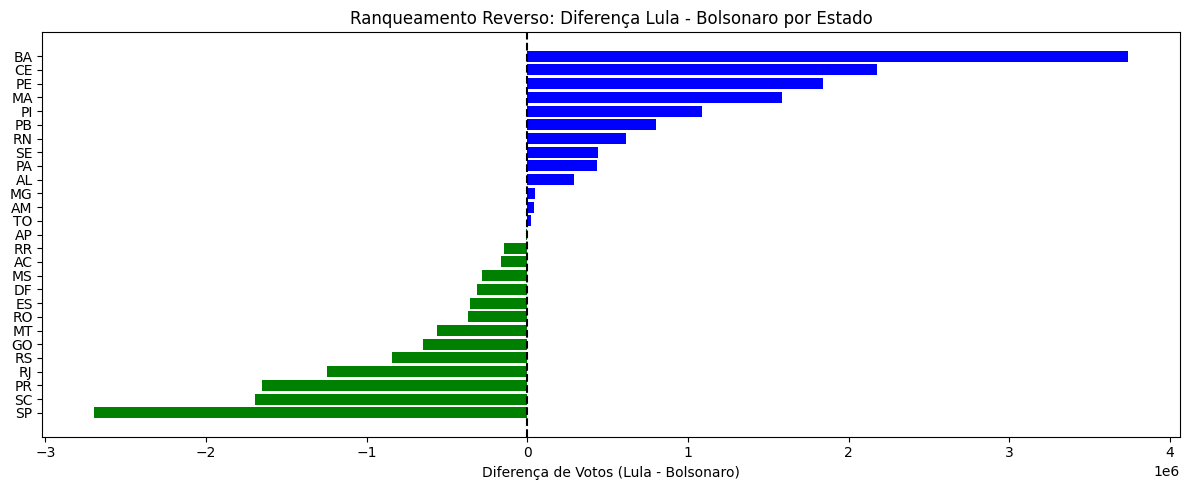

Visualização realizada com sucesso! Tempo de processamento:  0:00:00.959149


In [25]:
# ============================
# ETAPA 4: Correlação
# ============================

try:
    print('Correlacionando os dados')
    hora_inicial = datetime.now()

    dict_correlacoes = {}

    for candidato in df_votos_bolsa_familia['NM_VOTAVEL'].unique():
        df_candidato = df_votos_bolsa_familia.filter(pl.col('NM_VOTAVEL') == candidato)
        array_votos = np.array(df_candidato['QT_VOTOS'])
        array_valor_parcela = np.array(df_candidato['VALOR PARCELA'])
        correlacao = np.corrcoef(array_votos, array_valor_parcela)[0, 1]
        print(f'Correlação para {candidato}: {correlacao}')
        dict_correlacoes[candidato] = correlacao

    hora_final = datetime.now()
    print(f'Correlação finalizada em {hora_final - hora_inicial}')

except Exception as e:
    print(f'Erro ao processar os dados: {e}')


# ============================
# ETAPA 5: Visualização
# ============================

try:
    print('Visualizando dados....')
    hora_inicio = datetime.now()

    plt.subplots(2, 2, figsize=(17, 7))
    plt.suptitle('Votação x Bolsa Família', fontsize=16)

    # Lula
    plt.subplot(2, 2, 1)
    plt.title('Lula')
    df_lula = df_votos_bolsa_familia.filter(pl.col('NM_VOTAVEL') == 'LUIZ INÁCIO LULA DA SILVA').sort('QT_VOTOS', descending=True)
    plt.bar(df_lula['SG_UF'], df_lula['QT_VOTOS'])

    # Bolsonaro
    plt.subplot(2, 2, 2)
    plt.title('Bolsonaro')
    df_bolsonaro = df_votos_bolsa_familia.filter(pl.col('NM_VOTAVEL') == 'JAIR MESSIAS BOLSONARO').sort('QT_VOTOS', descending=True)
    plt.bar(df_bolsonaro['SG_UF'], df_bolsonaro['QT_VOTOS'])

    # Bolsa Família
    plt.subplot(2, 2, 3)
    plt.title('Valor Parcela')
    df_bolsa_familia = df_bolsa_familia.sort('VALOR PARCELA', descending=True)
    plt.bar(df_bolsa_familia['UF'], df_bolsa_familia['VALOR PARCELA'])

    # Correlações
    plt.subplot(2, 2, 4)
    plt.title('Correlações')
    x, y = 0.2, 0.6
    for candidato, correlacao in dict_correlacoes.items():
        plt.text(x, y, f'{candidato}: {correlacao:.3f}', fontsize=12)
        y -= 0.2
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Ranqueamento Reverso separado
    plt.figure(figsize=(12, 5))
    plt.title('Ranqueamento Reverso: Diferença Lula - Bolsonaro por Estado')
    df_plot = df_pivot.sort('DIF_LULA_MENOS_BOLSONARO')
    plt.barh(df_plot['SG_UF'], df_plot['DIF_LULA_MENOS_BOLSONARO'],
             color=np.where(df_plot['DIF_LULA_MENOS_BOLSONARO'] > 0, 'blue', 'green'))
    plt.axvline(x=0, color='black', linestyle='--')
    plt.xlabel("Diferença de Votos (Lula - Bolsonaro)")
    plt.tight_layout()
    plt.show()

    hora_fim = datetime.now()
    print('Visualização realizada com sucesso! Tempo de processamento: ', hora_fim - hora_inicio)

except Exception as e:
    raise RuntimeError(f"Erro ao visualizar dados: {e}")

Gerando gráficos de dispersão...


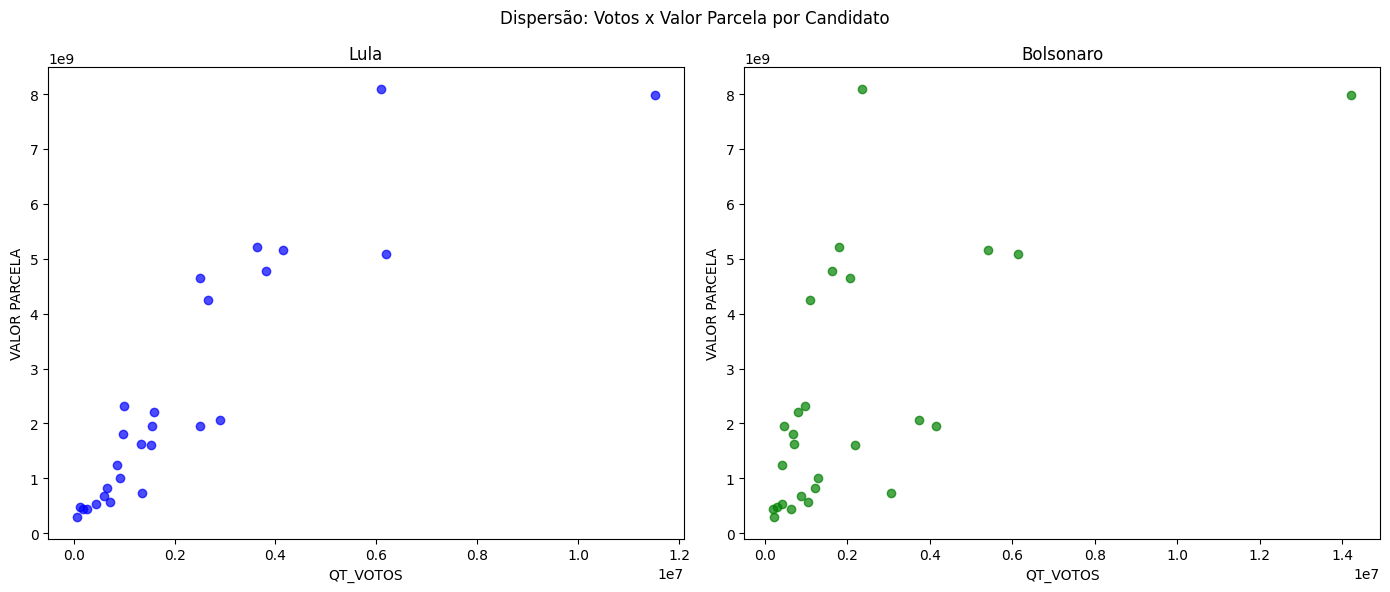

Gráficos de dispersão gerados com sucesso! Tempo de processamento:  0:00:00.337324


In [26]:
# ============================
# ETAPA 6: Dispersão
# ============================

try:
    print('Gerando gráficos de dispersão...')
    hora_inicio = datetime.now()

    plt.figure(figsize=(14, 6))
    plt.suptitle('Dispersão: Votos x Valor Parcela por Candidato')

    # Lula
    plt.subplot(1, 2, 1)
    plt.scatter(df_lula['QT_VOTOS'], df_lula['VALOR PARCELA'], alpha=0.7, color='blue')
    plt.title('Lula')
    plt.xlabel('QT_VOTOS')
    plt.ylabel('VALOR PARCELA')

    # Bolsonaro
    plt.subplot(1, 2, 2)
    plt.scatter(df_bolsonaro['QT_VOTOS'], df_bolsonaro['VALOR PARCELA'], alpha=0.7, color='green')
    plt.title('Bolsonaro')
    plt.xlabel('QT_VOTOS')
    plt.ylabel('VALOR PARCELA')

    plt.tight_layout()
    plt.show()

    hora_fim = datetime.now()
    print('Gráficos de dispersão gerados com sucesso! Tempo de processamento: ', hora_fim - hora_inicio)

except Exception as e:
    print(f'Erro ao gerar gráficos de dispersão: {e}')